In [1]:
import keras
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import math
import os
from keras.layers import *
from keras.models import *
from keras.optimizers import *

Using TensorFlow backend.


In [2]:
MANIFEST_DIR = r'E:\A_Shi_Chuang\cnn_-frft_-data-master\train\frfttrain1.0.csv'
Batch_size = 30
Long = 800
Lens = 200
def convert2oneHot(index, lens):
    hot = np.zeros((lens,))
    hot[int(index)] = 1
    return(hot)


In [3]:
def xs_gen(path=MANIFEST_DIR, batch_size=Batch_size, train=True, Lens=Lens):
    img_list = pd.read_csv(path)
    if train:
        img_list = np.array(img_list)[:Lens]
        print("Found %s train items." % len(img_list))
        print("list 1 is", img_list[0, -1])
        steps = math.ceil(len(img_list) / batch_size)
    else:
        img_list = np.array(img_list)[Lens:]
        print("Found %s test items." % len(img_list))
        print("list 1 is", img_list[0, -1])
        steps = math.ceil(len(img_list) / batch_size)
    while True:
        for i in range(steps):
            batch_list = img_list[i * batch_size: i * batch_size + batch_size]
            np.random.shuffle(batch_list)
            batch_x = np.array([file for file in batch_list[:, 1:-1]])
            batch_y = np.array([convert2oneHot(label, 4) for label in batch_list[:, -1]])
            yield batch_x, batch_y


TEST_MANIFEST_DIR = r'E:\A_Shi_Chuang\cnn_-frft_-data-master\test\frfttest1.0.csv'

In [4]:
def ts_gen(path=TEST_MANIFEST_DIR, batch_size=Batch_size):
    img_list = pd.read_csv(path)
    img_list = np.array(img_list)[:Lens]
    print("Found %s test items." % len(img_list))
    print("list 1 is", img_list[0, -1])
    steps = math.ceil(len(img_list) / batch_size)
    while True:
        for i in range(steps):
            batch_list = img_list[i * batch_size:i * batch_size + batch_size]
            batch_x = np.array([file for file in batch_list[:, 1:]])
            yield batch_x


TIME_PERIODS = 5000


In [5]:
def build_model(input_shape=(TIME_PERIODS,), num_classes=4):
    model = Sequential()
    model.add(Reshape((TIME_PERIODS, 1), input_shape=input_shape))

    model.add(Conv1D(16, 8, strides=2, activation='relu', input_shape=(TIME_PERIODS, 1)))
    model.add(Conv1D(16, 8, strides=2, activation='relu', padding="same"))
    model.add(MaxPooling1D(2))

    model.add(Conv1D(64, 4, strides=2, activation='relu', padding="same"))
    model.add(Conv1D(64, 4, strides=2, activation='relu', padding="same"))
    model.add(MaxPooling1D(2))

    model.add(Conv1D(256, 4, strides=2, activation='relu', padding="same"))
    model.add(Conv1D(256, 4, strides=2, activation='relu', padding="same"))
    model.add(MaxPooling1D(2))

    model.add(Conv1D(512, 2, strides=1, activation='relu', padding="same"))
    model.add(Conv1D(512, 2, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2))

    """ model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))"""

    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    return(model)


Train = True

In [6]:
if __name__ == "__main__":
    if Train == True:
        train_iter = xs_gen()
        val_iter = xs_gen(train=False)

        ckpt = keras.callbacks.ModelCheckpoint(
            filepath='best_model.{epoch:02d}-{val_loss:.4f}.h5',
            monitor='val_loss', save_best_only=True, verbose=1
        )

        model = build_model()
        opt = Adam(0.0002)
        model.compile(loss='categorical_crossentropy',
                      optimizer = opt, metrics=['accuracy'])
        print(model.summary())

        train_history = model.fit_generator(
            generator=train_iter,
            steps_per_epoch=Lens // Batch_size,
            epochs=25,
            initial_epoch=0,
            validation_data=val_iter,
            validation_steps=(Long - Lens) // Batch_size,
            callbacks=[ckpt],
        )

        model.save("finishModel.h5")
    else:
        test_iter = ts_gen()
        model = load_model("best_model.49-0.00.h5")
        pres = model.predict_generator(generator=test_iter, steps=math.ceil(528 / Batch_size), verbose=1)
        print(pres.shape)
        ohpres = np.argmax(pres, axis=1)
        print(ohpres.shape)
        df = pd.DataFrame()
        df["id"] = np.arange(1, len(ohpres) + 1)
        df["label"] = ohpres
        df.to_csv("predicts.csv", index=None)
        test_iter = ts_gen()
        for x in test_iter:
            x1 = x[0]
            break
        plt.plot(x1)
        plt.show()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 5000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2497, 16)          144       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1249, 16)          2064      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 624, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 312, 64)           4160      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 156, 64)           16448     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 78, 64)           

In [7]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.ylabel('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

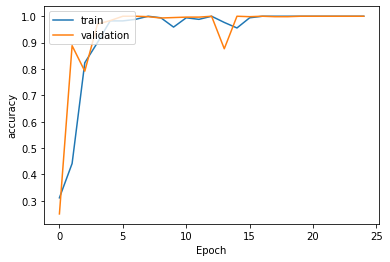

In [8]:
show_train_history(train_history, 'accuracy', 'val_accuracy')

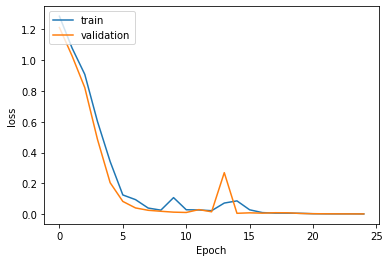

In [9]:
show_train_history(train_history, 'loss', 'val_loss')

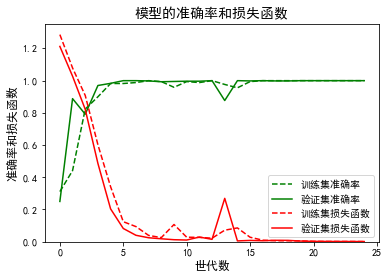

In [10]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(6, 4))
plt.plot(train_history.history['accuracy'], "g--", label="训练集准确率")
plt.plot(train_history.history['val_accuracy'], "g", label="验证集准确率")
plt.plot(train_history.history['loss'], "r--", label="训练集损失函数")
plt.plot(train_history.history['val_loss'], "r", label="验证集损失函数")
plt.title('模型的准确率和损失函数', fontsize=14)
plt.ylabel('准确率和损失函数', fontsize=12)
plt.xlabel('世代数', fontsize=12)
plt.ylim(0)
plt.legend()
plt.show()

In [13]:
testdata = train_history.history['val_accuracy']
df = pd.DataFrame(testdata)
df.to_csv(r'E:\A_Shi_Chuang\cnn_-frft_-data-master\daochu.csv')

In [14]:
file = r"E:\A_Shi_Chuang\cnn_-frft_-data-master\label\shiyong22.csv"

In [15]:
all_df = pd.read_csv(file)

In [16]:
ndarray = all_df.values

In [17]:
ndarray[:2]

array([[1],
       [1]], dtype=int64)

In [18]:
test_iter = ts_gen()
pres = model.predict_generator(generator=test_iter, steps=math.ceil(520 / Batch_size), verbose=1)
print(pres.shape)

Found 200 test items.
list 1 is 2.018626134
18/18 [==============================] - 1s 44ms/step
(520, 4)


In [19]:
print(ndarray.shape)

(200, 1)


In [20]:
ohpres = np.argmax(pres, axis=1)
print(ohpres.shape)
ohpres=ohpres[:200]
ohpres

(520,)


array([0, 0, 1, 1, 0, 0, 1, 1, 1, 3, 0, 3, 0, 1, 0, 0, 3, 3, 2, 1, 2, 3,
       3, 2, 0, 1, 2, 1, 3, 2, 3, 1, 2, 3, 0, 2, 3, 2, 1, 0, 1, 0, 0, 2,
       3, 3, 1, 1, 1, 1, 3, 0, 2, 1, 1, 1, 3, 2, 3, 1, 1, 3, 1, 0, 0, 2,
       2, 1, 2, 2, 0, 1, 0, 3, 2, 2, 3, 1, 3, 1, 3, 1, 0, 3, 1, 0, 3, 1,
       3, 2, 2, 0, 1, 3, 3, 2, 3, 3, 2, 2, 2, 2, 3, 1, 1, 0, 0, 0, 0, 1,
       2, 0, 0, 2, 1, 3, 3, 1, 0, 2, 1, 0, 0, 0, 1, 3, 0, 2, 1, 1, 0, 1,
       0, 1, 3, 2, 3, 2, 3, 0, 0, 1, 3, 3, 1, 1, 0, 3, 3, 0, 3, 0, 1, 1,
       1, 3, 1, 2, 0, 1, 1, 0, 0, 0, 1, 3, 0, 2, 1, 1, 0, 1, 0, 1, 3, 2,
       3, 2, 3, 0, 0, 1, 3, 3, 1, 1, 0, 3, 3, 0, 3, 0, 1, 1, 1, 3, 1, 2,
       0, 1], dtype=int64)

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def cm_plot(original_label, predict_label, pic=None):
    cm = confusion_matrix(original_label, predict_label)
    plt.figure()
    plt.matshow(cm, cmap=plt.cm.GnBu)
    plt.colorbar()
    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(cm[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    plt.title('Confusion Matrix')
    if pic is not None:
        plt.savefig(str(pic) + '.jpg')
    plt.show()

<Figure size 432x288 with 0 Axes>

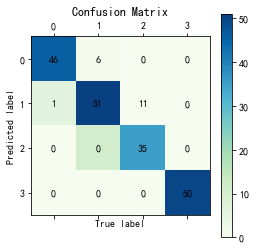

In [22]:
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
cm_plot(ndarray, ohpres)

In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(ndarray, ohpres)

0.91

In [24]:
train_history.history['loss']

[1.2859290440877278,
 1.0789686090805952,
 0.9081638104775372,
 0.6019955680650824,
 0.34134506127413583,
 0.12427015865550321,
 0.09375548439429086,
 0.03900409691656629,
 0.025454848566476035,
 0.10685813772108625,
 0.027991828289540374,
 0.026795213055961272,
 0.02184582655044163,
 0.07153926406274824,
 0.08564907040757437,
 0.0276493768700782,
 0.009535215500577846,
 0.0061657177421319135,
 0.005971780430306406,
 0.004913349348284742,
 0.0022332502446849554,
 0.001572727778693661,
 0.001361880509648472,
 0.0015147413257235551,
 0.000935323050190859]

In [25]:
train_history.history['val_loss']

[1.2125493288040161,
 1.0277326107025146,
 0.8218408823013306,
 0.485841304063797,
 0.20383983850479126,
 0.08210337162017822,
 0.039826299995183945,
 0.02451886609196663,
 0.018116451799869537,
 0.012406202964484692,
 0.010347860865294933,
 0.028925765305757523,
 0.014773608185350895,
 0.2691551744937897,
 0.004931285046041012,
 0.008006825111806393,
 0.005900627467781305,
 0.008707771077752113,
 0.008265401236712933,
 0.0039613754488527775,
 0.002305080881342292,
 0.0017596271354705095,
 0.0014107772149145603,
 0.0011355784954503179,
 0.0009649559506215155]

In [26]:
train_history.history['val_accuracy']

[0.25,
 0.8883333206176758,
 0.7916666865348816,
 0.9700000286102295,
 0.9833333492279053,
 1.0,
 1.0,
 0.9983333349227905,
 0.9933333396911621,
 0.9950000047683716,
 0.996666669845581,
 0.996666669845581,
 1.0,
 0.8766666650772095,
 1.0,
 0.9983333349227905,
 1.0,
 0.9983333349227905,
 0.9983333349227905,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [27]:
train_history.history['accuracy']

[0.31111112,
 0.44117647,
 0.8235294,
 0.9,
 0.9823529,
 0.9823529,
 0.9882353,
 1.0,
 0.9941176,
 0.9588235,
 0.9941176,
 0.9882353,
 1.0,
 0.9764706,
 0.95555556,
 0.9941176,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]